# Create a GeoZarr with multi-scales containing the WebMercatorQuad TMS

## Load example dataset from NetCDF into Xarray

In [1]:
import json

import cf_xarray  # noqa
import dask.array as da
import matplotlib.pyplot as plt
import morecantile
import numpy as np
import panel
import rasterio
import rioxarray  # noqa
import xarray as xr
import zarr

# For zarr_format=2 encoding
from numcodecs import Zstd
from rio_tiler.io.xarray import XarrayReader

In [2]:
fp_base = "20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1"
input = f"../data/{fp_base}.nc"
v2_output = f"../output/v2/{fp_base}_multiscales.zarr"

In [3]:
ds = xr.open_dataset(input)

## Check that all variables have a CF-compliant standard name


In [4]:
standard_names = ds.cf.standard_names
vars_with_standard_names = [v[0] for v in ds.cf.standard_names.values()]
compliant_vars = []
non_complaint_vars = []
for var in ds.variables:
    if var not in vars_with_standard_names:
        non_complaint_vars.append(var)
    else:
        compliant_vars.append(var)
        assert ds[var].attrs["standard_name"]

print(f"These variables do NOT have a CF-compliant standard name: {non_complaint_vars}")
print(f"These variables have a CF-compliant standard name: {compliant_vars}")

These variables do NOT have a CF-compliant standard name: ['analysis_error', 'mask']
These variables have a CF-compliant standard name: ['time', 'lat', 'lon', 'analysed_sst', 'sea_ice_fraction']


Not all the variables in this dataset have a CF-compliant standard name. See https://github.com/zarr-developers/geozarr-spec/issues/60 for a recommendation that CF-compliant standard names should be a "SHOULD" rather than a "MUST" condition in the GeoZarr spec. For now, let's subset to the variables that do use CF-compliant standard names.

In [5]:
ds = ds[compliant_vars]

## Assign CRS information to an auxiliary variable using rioxarray

In [6]:
ds = ds.rio.write_crs("epsg:4326")
# Specify which variable contains CRS information using grid_mapping
for var in ds.data_vars:
    ds[var].attrs["grid_mapping"] = "spatial_ref"

## Specify that the `analysed_sst` variable will contain multiscales up to zoom level 2

In [7]:
ds["analysed_sst"].attrs["multiscales"] = {
    "tile_matrix_set": "WebMercatorQuad",
    "resampling_method": "nearest",
    "tile_matrix_limits": {"0": {}, "1": {}, "2": {}},
}

## Specify encoding and write to Zarr V2 format

In [8]:
spatial_chunk = 4096
compressor = Zstd(level=1)
encoding = {
    "analysed_sst": {
        "chunks": (1, spatial_chunk, spatial_chunk),
        "compressor": compressor,
    },
    "sea_ice_fraction": {
        "chunks": (1, spatial_chunk, spatial_chunk),
        "compressor": compressor,
    },
}
ds.to_zarr(v2_output, mode="w", consolidated=True, zarr_format=2, encoding=encoding)

## Create an empty xarray Dataset for each zoom level

In [9]:
tms = morecantile.tms.get("WebMercatorQuad")
tileWidth = 256
var = "analysed_sst"
dataset_length = ds[var].sizes["time"]
zoom_levels = [0, 1, 2]


def create_overview_template(var, standard_name, *, tileWidth, dataset_length, zoom):
    width = 2**zoom * tileWidth
    overview_da = xr.DataArray(
        da.empty(
            shape=(dataset_length, width, width),
            dtype=np.float32,
            chunks=(1, tileWidth, tileWidth),
        ),
        dims=ds[var].dims,
    )
    template = overview_da.to_dataset(name=var)
    template = template.rio.write_crs("epsg:3857")
    # Convert transform to GDAL's format
    transform = rasterio.transform.from_bounds(*tms.xy_bbox, width, width)
    transform = transform.to_gdal()
    # Convert transform to space separated string
    transform = " ".join([str(i) for i in transform])
    # Save as an attribute in the `spatial_ref` variable
    template["spatial_ref"].attrs["GeoTransform"] = transform
    template[var].attrs["grid_mapping"] = "spatial_ref"
    template[var].attrs["standard_name"] = standard_name
    return template

## Write overview template (with no data) to zarr store

In [10]:
for zoom in zoom_levels:
    template = create_overview_template(
        var,
        ds[var].attrs["standard_name"],
        tileWidth=tileWidth,
        dataset_length=dataset_length,
        zoom=zoom,
    )
    template.to_zarr(
        v2_output,
        group=str(zoom),
        compute=False,
        consolidated=False,
        mode="w",
        zarr_format=2,
    )

## Populate Zarr array with overview data

In [11]:
def populate_tile_data(dst: XarrayReader, za: zarr.Array, x: int, y: int, zoom: int):
    x_start = x * tileWidth
    x_stop = (x + 1) * tileWidth
    y_start = y * tileWidth
    y_stop = (y + 1) * tileWidth
    tile = dst.tile(x, y, zoom).data
    za[:, y_start:y_stop, x_start:x_stop] = tile

In [12]:
matrices = tms.tileMatrices

with XarrayReader(ds[var]) as dst:
    for zoom in zoom_levels:
        tm = matrices[zoom]
        za = zarr.open_array(v2_output, path=f"{zoom}/{var}", zarr_version=2)
        for x in range(tm.matrixWidth):
            for y in range(tm.matrixHeight):
                populate_tile_data(dst, za, x, y, zoom)

# Consolidate metadata at the root of the Zarr store

In [13]:
zarr.consolidate_metadata(v2_output)

<Group file://../output/v2/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_multiscales.zarr>

## Plot one of the zoom levels

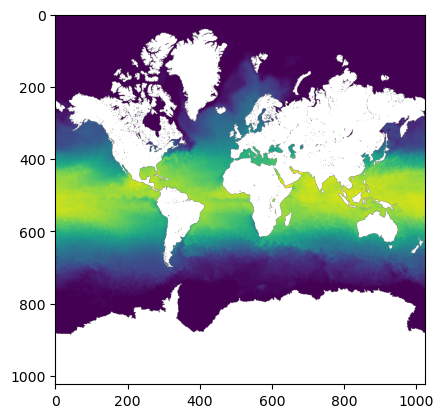

In [14]:
var = "analysed_sst"
zoom = 2
arr = zarr.open_array(v2_output, path=f"{zoom}/{var}")
arr = arr[:]
plt.imshow(arr.squeeze())

## Inspect Zarr V2 store

First, let's look at the structure of Zarr arrays using zarr's `Group.tree()` method

In [15]:
root = zarr.open_group(v2_output)
root.tree()

/
├── 0
│   ├── analysed_sst (1, 256, 256) float32
│   └── spatial_ref () int64
├── 1
│   ├── analysed_sst (1, 512, 512) float32
│   └── spatial_ref () int64
├── 2
│   ├── analysed_sst (1, 1024, 1024) float32
│   └── spatial_ref () int64
├── analysed_sst (1, 17999, 36000) float64
├── lat (17999,) float32
├── lon (36000,) float32
├── sea_ice_fraction (1, 17999, 36000) float64
├── spatial_ref () int64
└── time (1,) int32

Second, let's look at what's actually recorded in the Zarr metadata using the consolidated metadata at the root of the Zarr store.

In order to match valid JSON, we convert the nan fill_value entries to "nan".

### Key observations

- For each array, metadata is stored under '.zattrs'
- All arrays contain a `.zattrs/standard_name`
- The root group specifies that the metadata follows CF conventions, which should be validated.
- `.zattrs/_ARRAY_DIMENSIONS` for `lat`, `lon`, and `time` contains a list with only the the name of the array, indicating that they are coordinates variables.
- `.zattrs/_ARRAY_DIMENSIONS` for `spatial_ref` contains an empty list, indicating that it is an auxiliary coordinate.
- `.zattrs/_ARRAY_DIMENSIONS` for `analysed_sst`, `sea_ice_fraction` contain a list referring to other arrays, indicating that they are data variables rather than coordinate variables.
- `.zattrs/grid_mapping` for  `analysed_sst`, `sea_ice_fraction` is `"spatial_ref"` indicating that CRS information is included in that auxiliary variable's metadata.
- `spatial_ref/.zattrs` contains the OGC WKT for the CRS.
- `.zattrs/multiscales` contains information about the multiscales, specifying that they are a `WebMercatorQuad` TMS created using `nearest` resampling
- The `0`, `1`, and `2` groups contain GeoZarr compliant overviews for the `analysed_sst` variable, including the required `standard_name` and `grid_mapping` attributes.


In [16]:
panel.extension()
consolidated_metadata_file = f"{v2_output}/.zmetadata"
with open(consolidated_metadata_file) as f:
    metadata = json.load(f)["metadata"]
metadata["sea_ice_fraction/.zarray"]["fill_value"] = str(
    metadata["sea_ice_fraction/.zarray"]["fill_value"]
)
metadata["analysed_sst/.zarray"]["fill_value"] = str(
    metadata["sea_ice_fraction/.zarray"]["fill_value"]
)
panel.pane.JSON(metadata, name="JSON")

BokehModel(combine_events=True, render_bundle={'docs_json': {'b482b91c-8da9-4201-8845-838c5948b9fa': {'version…